In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
%matplotlib inline
enrollments = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/enrollment.xls")
pd.set_option('display.max_columns', 500)

In [2]:
enrollments['Higher_Secondary_Boys']=enrollments['Higher_Secondary_Boys'].astype('float')
enrollments['Higher_Secondary_Girls']=enrollments['Higher_Secondary_Girls'].astype('int')
enrollments['Higher_Secondary_Total']=enrollments['Higher_Secondary_Total'].astype('int')

In [3]:
print("\n Correlation between enrollment rates at different stages of schooling\n")
enrollments[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']].corr().style.background_gradient(cmap='RdBu')


 Correlation between enrollment rates at different stages of schooling



,Primary_Total,Upper_Primary_Total,Secondary_Total,Higher_Secondary_Total
Primary_Total,1.000000,0.698719,0.064725,-0.203437
Upper_Primary_Total,0.698719,1.000000,0.541461,0.070695
Secondary_Total,0.064725,0.541461,1.000000,0.602627
Higher_Secondary_Total,-0.203437,0.070695,0.602627,1.000000


In [4]:
states=[]
for i in range(1,37):
    states.append(enrollments.State_UT.iloc[3*i])
states=pd.DataFrame(states, columns=['State'])
enrollments.drop(['State_UT','Year'],axis=1,inplace=True)
x=pd.DataFrame()
for i in range(36):
    x[i]=enrollments.iloc[3*i+0:i*3+3,:].mean()
x=x.transpose() 

In [5]:
def create_clusters(x):

    scores=[]
    for i in range(4,36):
        k=KMeans(n_clusters=i,n_init=500, max_iter=500)
        k.fit(x[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']])
        label=KMeans.predict(k,x[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']])
        scores.append(silhouette_score(x, label))

    pd.DataFrame(scores).plot()
    best_cluster_no=np.argmax(scores[2:36])+2
    plt.axvline(best_cluster_no)
    plt.text(best_cluster_no, 0.34,s=f"Max silhoutte score at n={best_cluster_no}")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte score")
    
    kk=KMeans(n_clusters=best_cluster_no)
    kk.fit(x[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']])
    lab = pd.DataFrame(kk.labels_,columns=['Labels'])
    result=pd.concat([states['State'],x,lab['Labels']],axis=1)
    return result

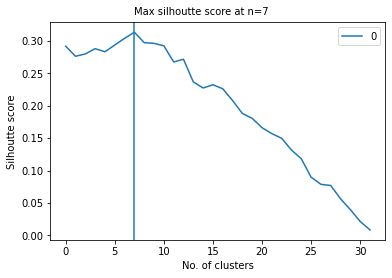

In [6]:
result=create_clusters(x)

In [8]:
grouping=result[['State','Labels']]
clusters=pd.DataFrame()
for l in grouping.Labels.unique():
    clusters=pd.concat([clusters,pd.Series(np.array(grouping.State[grouping.Labels==l]), name=f"Cluster {l}").to_frame()],axis=1)
clusters.replace({np.nan:'-'},inplace=True)
clusters.sort_index(axis=1,inplace=True)
clusters

In [7]:
reqd=result.groupby('Labels')[result.columns[1:-1]].agg('mean')
reqd['Average dropout'] = (reqd[ 'Higher_Secondary_Total']+reqd['Secondary_Total']+reqd['Upper_Primary_Total']+reqd['Primary_Total'])/4
reqd.sort_values(['Average dropout'], ascending=False).style.background_gradient(cmap='Greens')

,Primary_Boys,Primary_Girls,Primary_Total,Upper_Primary_Boys,Upper_Primary_Girls,Upper_Primary_Total,Secondary_Boys,Secondary_Girls,Secondary_Total,Higher_Secondary_Boys,Higher_Secondary_Girls,Higher_Secondary_Total,Average dropout
Labels,,,,,,,,,,,,,
4,113.095000,111.406667,112.165000,127.556667,137.528333,134.396667,102.443333,111.910000,107.030000,72.963333,83.333333,77.666667,107.814583
2,131.499167,132.518333,131.998333,119.860833,126.560833,123.149167,90.527500,92.967500,91.733333,55.404167,56.000000,55.416667,100.574375
3,89.395000,87.218333,88.260000,99.408333,94.350000,96.591667,115.521667,116.781667,116.256667,97.875000,92.333333,94.666667,98.943750
6,93.745556,96.155556,94.812778,94.061667,96.625000,95.178333,96.756667,97.312778,96.960556,76.997778,85.000000,80.388889,91.835139
0,101.016250,102.741250,101.809167,94.915833,99.959583,97.216250,89.132083,89.624583,89.410000,60.675833,59.208333,59.833333,87.067188
1,100.199000,101.191000,100.655333,91.670000,97.120000,94.205667,74.819667,77.032667,75.804000,37.274333,39.400000,37.466667,77.032917
5,92.186667,93.449167,92.776667,78.453333,81.140000,79.675833,74.445000,71.027500,72.861667,61.542500,56.166667,58.750000,76.016042


In [12]:
result[['State','Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total','Labels']].to_csv('enrollments.csv')
clusters.to_csv('enrollments_clusters.csv')